Tissue mask using this model

|2024-04-23|16:23:09.486| [WARNING] /home/u1910100/miniconda3/envs/TIAToolBox/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()

|2024-04-23|16:23:09.487| [WARNING] /home/u1910100/miniconda3/envs/TIAToolBox/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details

'Processing TCGA-A4-7288-01Z-00-DX1.48597193-160b-486a-9711-f26d24dabeb5.svs'
'Loading model to cuda'


  0%|          | 0/66 [00:00<?, ?it/s]

'Task finished successfully'
{'objective_power': 40.0, 'slide_dimensions': (21103, 41154), 'level_count': 3, 'level_dimensions': ((21103, 41154), (5275, 10288), (1318, 2572)), 'level_downsamples': [1.0, 4.0003815608116575, 16.006079242549035], 'vendor': 'aperio', 'mpp': (0.252, 0.252), 'file_path': PosixPath('/home/u1910100/Documents/tcga/test/vis/slides/TCGA-A4-7288-01Z-00-DX1.48597193-160b-486a-9711-f26d24dabeb5.svs'), 'axes': 'YXS'}


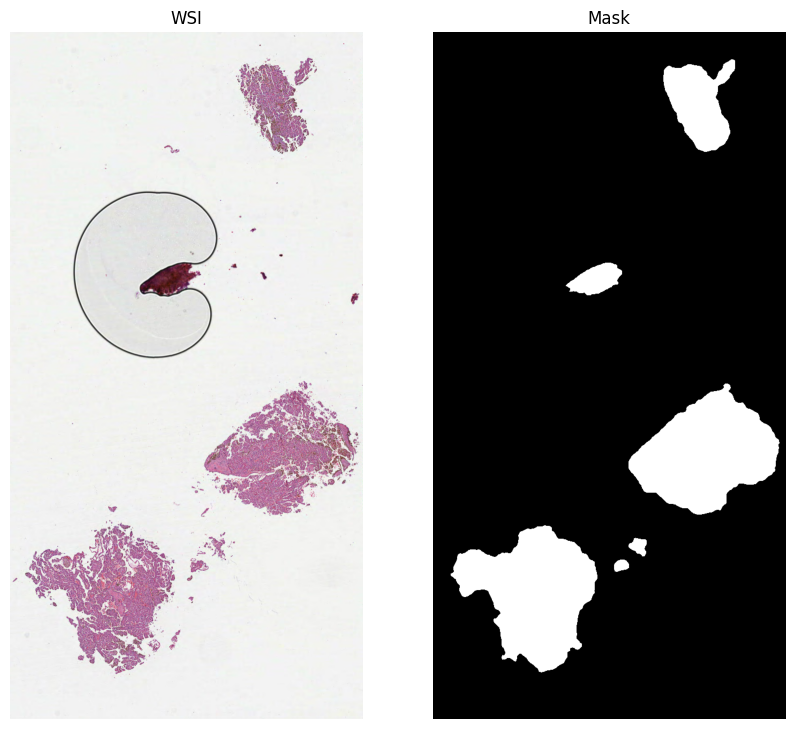

In [1]:
from tiatoolbox.wsicore.wsireader import WSIReader
from tissue_masker_lite import get_mask
import matplotlib.pyplot as plt

# input_wsi = "/Users/wildsquirrel/Library/CloudStorage/OneDrive-UniversityofWarwick/tissue_mask_demo_wsi/TCGA-08-0518-01Z-00-DX8.01f2c18c-09a8-4837-8619-62f1c9b82669.svs"
input_wsi = "/home/u1910100/Documents/tcga/test/vis/slides/TCGA-A4-7288-01Z-00-DX1.48597193-160b-486a-9711-f26d24dabeb5.svs"
save_dir = "./output"
model_weight_path = "tissue_masker_lite/model_weights/model_22.pth"
mask = get_mask(
    wsi_path=input_wsi,
    save_dir=save_dir,
    model_weight=model_weight_path,
    threshold=0.5,
    device="cuda",
    return_mask=True,
    save_mask=False,
)
reader = WSIReader.open(input_wsi)
print(reader.info.as_dict())
thumbnail = reader.slide_thumbnail(resolution=1.25, units="power")
fig, axes = plt.subplots(1, 2, figsize=(10, 10))
axes[0].imshow(thumbnail)
axes[0].title.set_text("WSI")
axes[0].axis("off")
axes[1].imshow(mask, cmap="gray")
axes[1].title.set_text("Mask")
axes[1].axis("off")
plt.show()

Tissue mask using tiatoolbox WSIReader.tissue_mask()

In [3]:
import numpy as np

print()

(1286, 659, 1)


In [ ]:
import numpy as np

mask_old = reader.tissue_mask().slide_thumbnail()
mask_old = np.where(mask_old >= 0.5, 1, 0)
fig, axes = plt.subplots(1, 2)
axes[0].imshow(thumbnail)
axes[1].imshow(mask_old, cmap="gray")
plt.show()

Tissue mask using tiatoolbox pretained fcn-tissue_mask model

In [ ]:
from tiatoolbox.models.engine.semantic_segmentor import (
    SemanticSegmentor,
    IOSegmentorConfig,
)
import shutil

tissue_segmentor = SemanticSegmentor(
    pretrained_model="fcn-tissue_mask",
    num_loader_workers=1,
    batch_size=1,
    auto_generate_mask=False,
)

tissue_segmentor_config = IOSegmentorConfig(
    input_resolutions=[{"units": "mpp", "resolution": 2}],
    output_resolutions=[{"units": "mpp", "resolution": 2}],
    patch_input_shape=[1024, 1024],
    patch_output_shape=[512, 512],
    stride_shape=[256, 256],
    save_resolution={"units": "mpp", "resolution": 8},
)


wsi_path = input_wsi
shutil.rmtree("sample_tile_results/", ignore_errors=True)
output = tissue_segmentor.predict(
    [wsi_path],
    save_dir="sample_tile_results/",
    mode="wsi",
    ioconfig=tissue_segmentor_config,
    on_gpu=True,
    crash_on_exception=True,
)

wsi_prediction_raw = np.load(
    "sample_tile_results/0.raw.0.npy",
)  # Loading the first prediction [0] based on the output address [1]

# Simple processing of the raw prediction to generate semantic segmentation task
wsi_prediction = np.argmax(
    wsi_prediction_raw,
    axis=-1,
)
# [WSI overview extraction]
# Now reading the WSI to extract it's overview
wsi = WSIReader.open(wsi_path)

# using the prediction save_resolution to create the wsi overview at the same resolution
overview_info = tissue_segmentor_config.save_resolution

# extracting slide overview using `slide_thumbnail` method
wsi_overview = wsi.slide_thumbnail(
    resolution=overview_info["resolution"],
    units=overview_info["units"],
)

fig, axes = plt.subplots(1, 2)
axes[0].imshow(wsi_overview)
axes[1].imshow(wsi_prediction, cmap="gray")
plt.show()